# 動画処理・動画解析

## OpticalFlow(オプティカルフロー)
- 特徴点を見つけて、追いかけていく画像処理

1. 特徴点を見つける
    - 特徴抽出器として用意されている関数がある
    - 
2. 特徴点とその周りは同じ方向を向くとして、flow ベクトルという流れを出す
    - flow ベクトルを出す
    - ものは物理の法則に従って動く = 規則性がある
    - flow ベクトルは自分自身だけではなく、周りの情報も利用して求めていく
3. 1, 2 を繰り返して特徴点を追跡していく

## Taylor 展開
- フローベクトルを求める際、特徴点がどんなふうに動いていくのか？
- $\delta$t 秒後にはある場所 = t から、ある場所 = t + $\delta$へ動いている

#### 式にすると下記のようになる
- I -> 画素値
$$
I(x,y,t)=I(x+\delta x,y+\delta y,t+\delta t)
$$

#### <u>上記の式を Taylor 展開</u>
$$
I(x+\delta x,y+\delta y,t+\delta t)=I(x,y,t)(1+\frac{\partial I}{\partial x}\delta x+\frac{\partial I}{\partial y}\delta y+\frac{\partial I}{\partial t}\delta t ) 
$$

#### <u>偏微分公式</u>
$$ \frac{\partial}{\partial a}( ) $$

- ディー（ラウンド）と呼ばれる
- a で偏微分する。　( ) は対象
- a 以外を定数だと仮定して微分する
- a 以外関係ないものは外に出して計算する
- a に関係ないものは 0 に置き換えて計算

$$
\frac{\partial I}{\partial x}=Ix　　　　　\frac{\delta x}{\partial t}=u,\frac{\partial y}{\partial t}=v
$$
- 上記の様において整理し

### <u>フローベクトルを求める方程式</u>
$$
I_xu+I_yv+I_t=0
$$

- 未知数は特徴点のフローベクトル(u,v):方程式が足りない
    - 特徴点の周囲の画素も同じような動きをする筈
    - 上の方程式をいくつか立てて、方程式の数を増やす

#### 下記の式は他の点でも成り立つ
- 船に例えた場合、どこかの特徴点１点を求めたとする。しかしそれでは数が足らないので、他の点もプラスする。
- 船というもの自体に変わりないので向かっている方向は別の点でも同じ方向に向かっている

$$
I(x,y,t)=I(x+\delta x,y+\delta y,t+\delta t)
$$

In [1]:
import cv2

In [2]:
# sizeが大きのでresize
cv2.namedWindow("img", cv2.WINDOW_NORMAL)
cv2.resizeWindow("img", 1200, 800)
COUNT = 500  # 1
criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, 20, 0.03) # 2
lk_params =dict(winSize=(10, 10), maxLevel=4, criteria=criteria)  # 3
cap = cv2.VideoCapture("data/movie/Cosmos.mp4")  # 4
ret, frame = cap.read()  # 5
frame_pre = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # 6
while True:  
    ret, frame = cap.read()  # 7
    if ret == False:
        break
    frame_now = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # 8
    feature_pre = cv2.goodFeaturesToTrack(frame_pre, COUNT, 0.001, 5)  # 9
    if feature_pre is None:  # 10
        continue
    feature_now, status, err = cv2.calcOpticalFlowPyrLK(frame_pre, frame_now, feature_pre, None, **lk_params)  # 11
    for i in range(COUNT):  # 12
        pre_x = int(feature_pre[i][0][0])  # 13
        pre_y = int(feature_pre[i][0][1])  # 14
        now_x = int(feature_now[i][0][0])
        now_y = int(feature_now[i][0][1])  
        cv2.line(frame, (pre_x, pre_y), (now_x, now_y), (255, 0, 0), 3)  # 15
    cv2.imshow("img", frame)  # 16
    frame_pre = frame_now.copy()  # 17
    if cv2.waitKey(10) == 27:  # 18
        break
cv2.destroyAllWindows()  # 19
cv2.waitKey(1)
cap.release() 

### 検出 video image

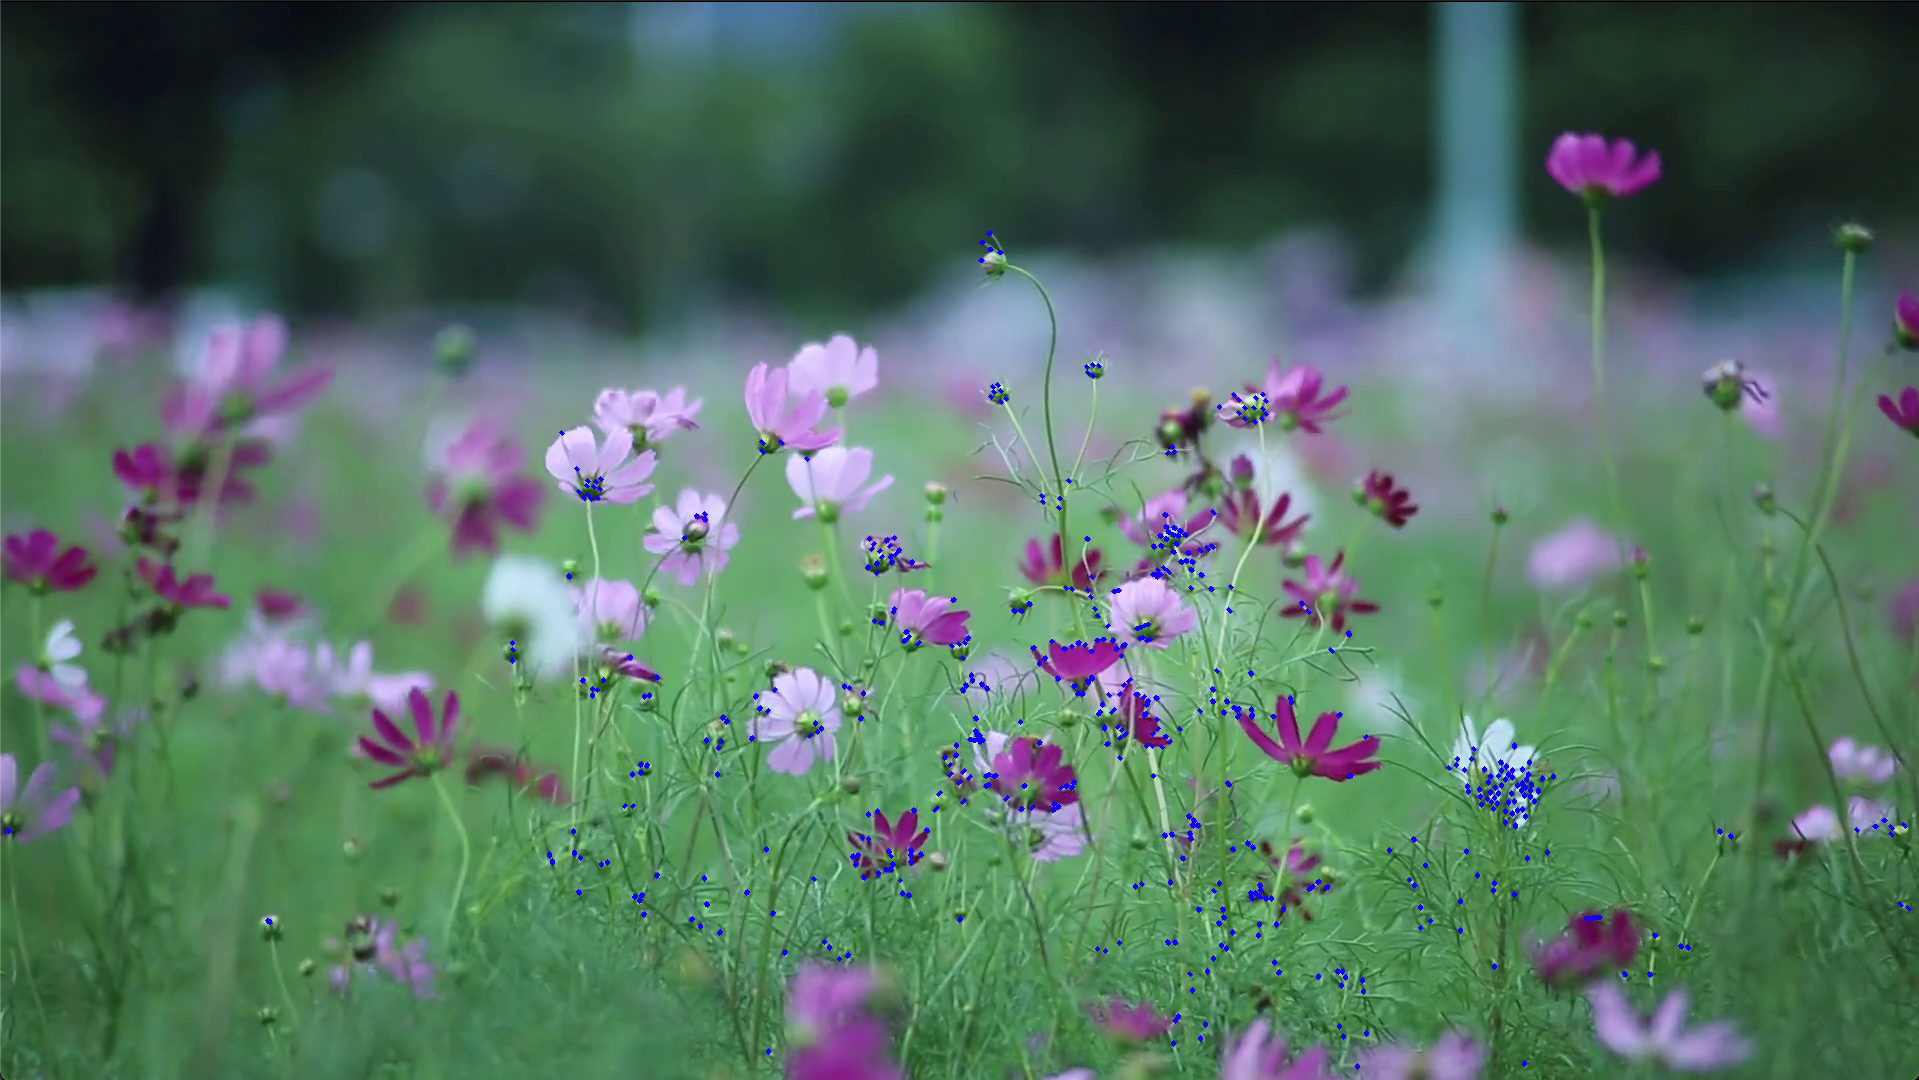

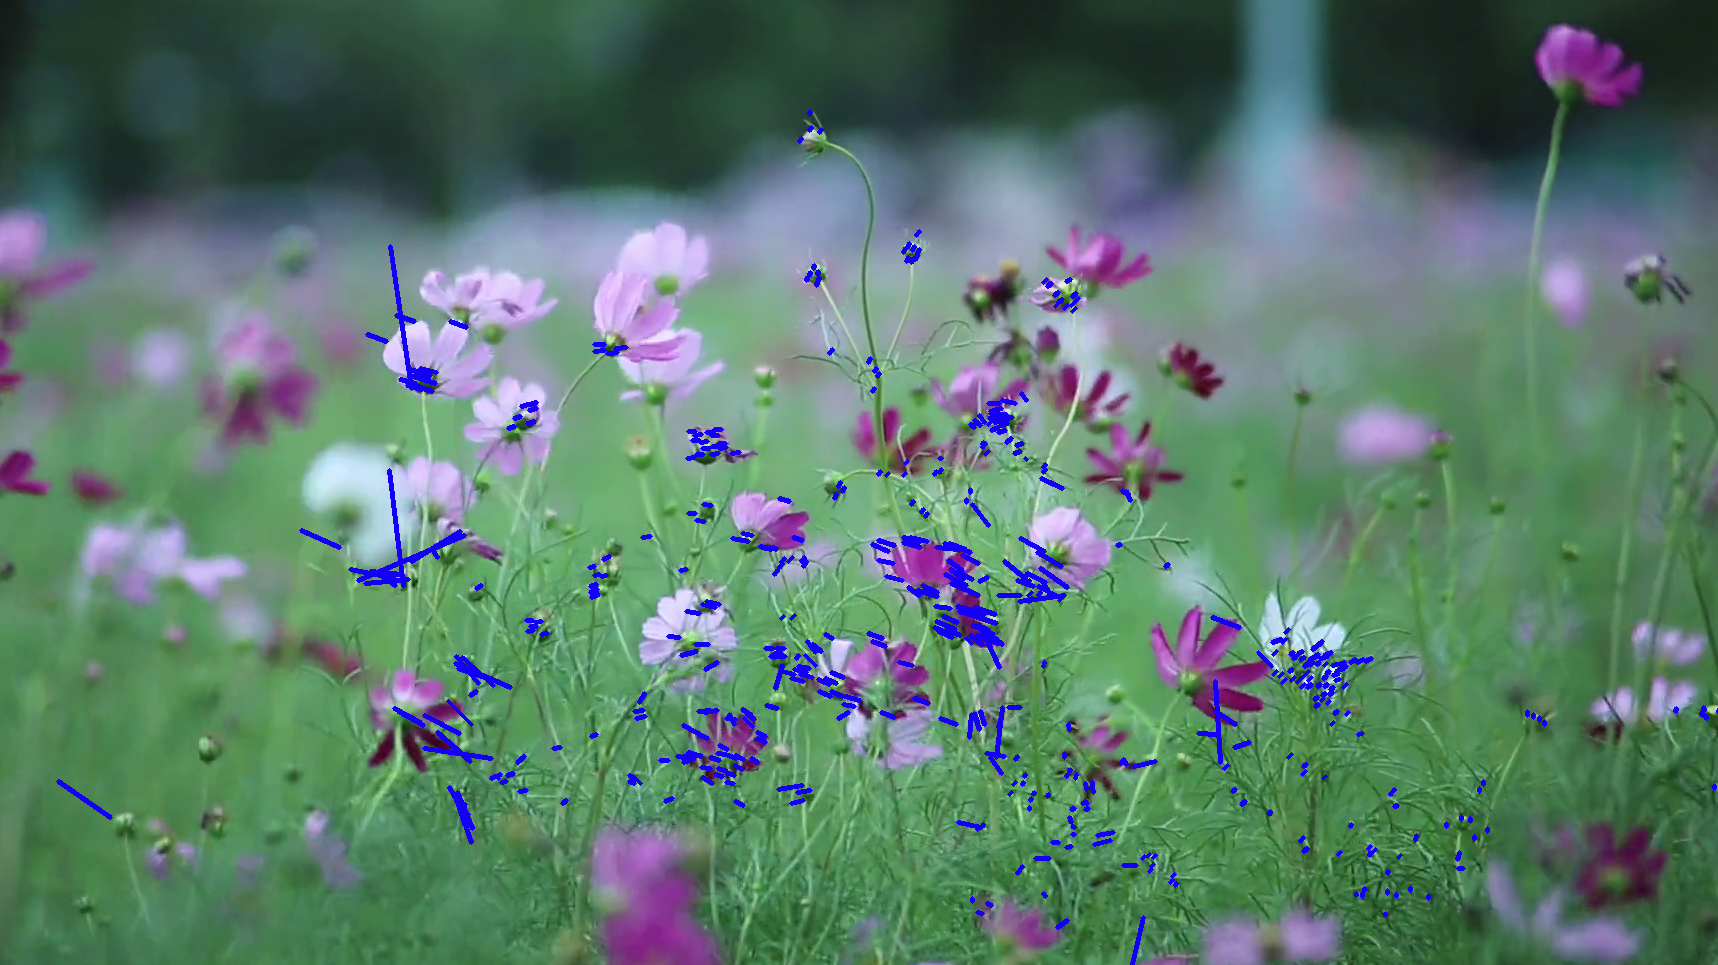

- コスモスが揺らいでいて、特徴点というものを <u>フローベクトル</u> を使用して直線で描かせている
    - あまり動きがないと点の様に見える
    - 風が吹くとフローベクトルの勢いが良くなり、直線で表現される

### OpticalFlow code 解析

1. 良い特徴点を検出する際に、500点検出する

2. オプティカルflow の収束条件 : 最大の反復回数 | もしくは動かなくなったら

3. ルーカスカナデという方法を使用する -> その際に使用するパラメーター = 探索する window size を指定 : ピラミッドの最大の数 : 収束条件
    - 今回のオプティカルフローは画像のピラミッドを用いる -> それに関するパラメーター
    - 画像の解像度が非常に大きい場合、真面目にやると非常に大変になってくる -> 画像の解像度を何段階かおとした物を用意しておく
    - 1番画像の解像度が荒いモノは、特徴点を追いやすい・さらにノイズを除いてもある程度の特徴点は残る。それの繰り返しで何度も繰り返す


4. 動画の読み込み

5. cap から 1コマだけ読み込んでくる

6. 前の画像をグレースケールに直しておく
    - 今回オプティカルフローをするには、前の画像と後の画像を使用してプロベクトルを出す


7. 現在の frame を読み込んでくる -> False であれば break

8. 現在の画像をグレースケールに直す

9. goodFeaturesToTrack : まずは最初は frame_pre から追いかけるべき特徴点を見つける : 500点の特徴点 : コーナー検出の際の精度 : コーナー間の最低限の距離
    - まず追いかけるべき特徴点を見つけないといけない    
    - cv2.goodFeaturesToTrack が特徴点を見つける為の関数


10. feature_pre の特徴点検出が無ければ、while文をやめてまた新たに frame を読み込んでくる

11. 10でなければ、 feature_now に特徴点を検出することができる
    - <u>cv2.calcOpticalFlowPyrLK</u>が今回のオプティカルフローの本体になる
    - 3つの出力値を返す -> feature_now を使用する
    - 前の画像と、今の画像と、追いかけるべき feature_now


12. あとは描くだけ。
13. 検出した今の特徴点の場所。前の特徴点の場所を結ぶ事によって　フローベクトルを描くことができる
14. こうすることによって始点と終点が計算できた
15. cv2.line をして　フローベクトルの書き込みを行なっていく / 始点・終点 : color : 線の太さ
16. frame を描く
17. 次のための準備が必要で frame_pre の更新。使ったものを今度は次の pre に　copy する
18. esc で break
19. あとは default の記述
    - 全てのウィンドウを閉じて、メモリの解放
